# Figure 2

_Comparison of success rate and average L2-norm versus number of model queries for untargeted (left) and targeted (right) attacks._

## Imports

In [2]:
# pylint: disable-msg=C0114,C0413,E0401,W0621,W0511,R0801

import os
import sys

module_path = os.path.abspath(os.path.join(".."))
sys.path.append(module_path)

import random  # noqa

import matplotlib.pyplot as plt  # noqa
import numpy as np  # noqa
import torch  # noqa
from torchvision import transforms  # noqa

from imagenet.imagenet import ImageNetDataSet  # noqa
from simple_blackbox_attack.cartesian_set import CartesianSearchVectors  # noqa
from simple_blackbox_attack.dct_set import DCTSearchVectors  # noqa
from simple_blackbox_attack.simba.simba import simba  # noqa

## DataSet

In [3]:
IMAGE_FOLDER = "../../../../shared/data/imagenet/val"
LABEL_FILE = "../../../../shared/data/imagenet/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt"
META_FILE = "../../../../shared/data/imagenet/ILSVRC2012_devkit_t12/data/meta.mat"

In [4]:
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
dataset = ImageNetDataSet(image_root=IMAGE_FOLDER, label_file=LABEL_FILE, meta_file=META_FILE, transform=preprocess)

## Model (ResNet50)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=True).to(DEVICE)
model.eval()

Using cache found in /home/dai/eko/.cache/torch/hub/pytorch_vision_v0.10.0
/home/dai/eko/.cache/pypoetry/virtualenvs/replicating-simple-blackbox-attack-BJnlChmF-py3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dai/eko/.cache/pypoetry/virtualenvs/replicating-simple-blackbox-attack-BJnlChmF-py3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Correctly classified images

In [6]:
indices = []
while len(indices) < 1000:
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    img = img.to(DEVICE)
    with torch.no_grad():
        logits = model(img.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(logits[0], dim=0)
    probs, predictions = torch.topk(probabilities, 1)
    if int(label) == predictions[0]:
        indices.append(sample_idx)

## Figure 2

In [7]:
NUMBER_IMAGES = 8

QUERY_RESOLUTION = 2048
success_rate = np.zeros((NUMBER_IMAGES, QUERY_RESOLUTION))
l2_norms = np.zeros((NUMBER_IMAGES, int(20000 / 64)))
success_rate_dct = np.zeros((NUMBER_IMAGES, QUERY_RESOLUTION))
l2_norms_dct = np.zeros((NUMBER_IMAGES, int(20000 / 64)))

for i in range(NUMBER_IMAGES):
    print(i)
    index = random.choice(indices)
    img, label = dataset[index]
    img = img.to(DEVICE)

    base = CartesianSearchVectors(img.size())
    base_dct = DCTSearchVectors(img.size(), 1 / 8)

    was_successful, _, _, queries, l2_norm = simba(model, img, int(label), base, 0.2, 200)
    if was_successful:
        print("cart successful")
        success_rate[i, int(queries / (20000 / QUERY_RESOLUTION)) :] = 1
        l2_norms[i, :] = np.pad(
            np.array(l2_norm),
            pad_width=(0, l2_norms.shape[1] - len(l2_norm)),
            mode="edge",
        )
    was_successful_dct, pertubation, _, queries_dct, l2_norm_dct = simba(model, img, int(label), base_dct, 0.2, 200)
    while len(base_dct.frequency_dimensions) == 0:  # not pretty but with current structure only this way possible
        base_dct = DCTSearchVectors(img.size(), 1 / 32)
        was_successful_dct, tmp_p, _, tmp_q, tmp_l2 = simba(model, img + pertubation, int(label), base_dct, 0.2, 1e10)
        pertubation += tmp_p
        queries_dct += tmp_q
        l2_norm_dct += tmp_l2
    if was_successful_dct:
        print("dct successful")
        success_rate_dct[i, int(queries_dct / (20000 / QUERY_RESOLUTION)) :] = 1
        l2_norms_dct[i, :] = np.pad(
            np.array(l2_norm_dct),
            pad_width=(0, l2_norms_dct.shape[1] - len(l2_norm_dct)),
            mode="edge",
        )

0
0: Label probability 0.5563 - queries 1
cart successful
0: Label probability 0.5563 - queries 1
dct successful
1
0: Label probability 0.6726 - queries 1
cart successful
0: Label probability 0.6726 - queries 1
dct successful
2
0: Label probability 0.9646 - queries 2
512: Label probability 0.8577 - queries 1288
1024: Label probability 0.5595 - queries 2653
cart successful
0: Label probability 0.9646 - queries 1
512: Label probability 0.4154 - queries 1211
dct successful
3
0: Label probability 0.3739 - queries 1
cart successful
0: Label probability 0.3739 - queries 2
dct successful
4
0: Label probability 0.9974 - queries 6
512: Label probability 0.9936 - queries 1277
1024: Label probability 0.9824 - queries 2616
1536: Label probability 0.9539 - queries 3916
2048: Label probability 0.8910 - queries 5302
2560: Label probability 0.7485 - queries 6642
cart successful
0: Label probability 0.9974 - queries 2
512: Label probability 0.9447 - queries 1195
1024: Label probability 0.5078 - queries

And plotting the results.

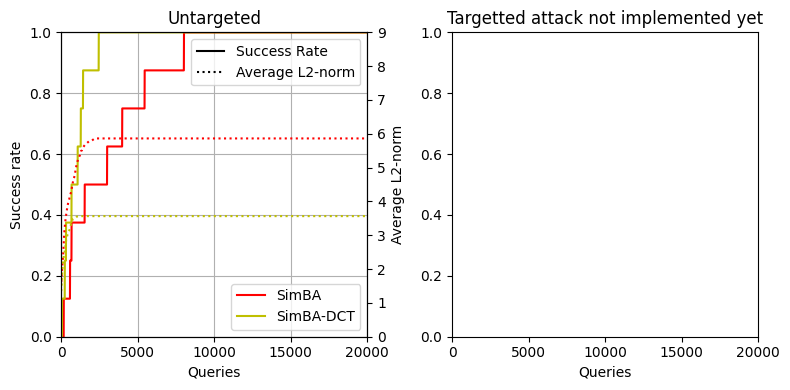

In [8]:
figure = plt.figure(figsize=(8, 4))
ax = figure.add_subplot(1, 2, 1)
ax.grid("on")
ax.plot(np.linspace(0, 20000, QUERY_RESOLUTION), success_rate.sum(axis=0) / NUMBER_IMAGES, color="r", label="SimBA")
ax.plot(
    np.linspace(0, 20000, QUERY_RESOLUTION), success_rate_dct.sum(axis=0) / NUMBER_IMAGES, color="y", label="SimBA-DCT"
)
plt.title("Untargeted")
plt.xlabel("Queries")
plt.xlim([0, 20000])
plt.ylabel("Success rate")
ax.set(ylim=[0, 1])

ax.legend(loc="lower right")

ax2 = ax.twinx()
ax2.spines["right"].set_position(("axes", 1.0))

ax2.set(ylim=[0, 9])
ax2.plot(
    np.linspace(0, 20000, int(20000 / 64)), l2_norms[l2_norms.sum(axis=1) != 0].mean(axis=0), color="r", linestyle=":"
)
ax2.plot(
    np.linspace(0, 20000, int(20000 / 64)),
    l2_norms_dct[l2_norms_dct.sum(axis=1) != 0].mean(axis=0),
    color="y",
    linestyle=":",
)
ax2.plot(0, 0, color="k", label="Success Rate")
ax2.plot(0, 0, color="k", label="Average L2-norm", linestyle=":")
plt.ylabel("Average L2-norm")

ax2.legend()

ax = figure.add_subplot(1, 2, 2)
plt.title("Targetted attack not implemented yet")
plt.xlabel("Queries")
plt.xlim([0, 20000])
plt.tight_layout()
plt.show()